In [87]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='519ff1cf-89c3-4956-933c-3c9da1680def', project_access_token='p-341db2865cf4826e1cb05e95b0092c98d7517f8d')
pc = project.project_context


# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

[**Part 0: Get to Know The Data**](#part0)<br>
[Part 0.1: Load in the Data](#part0.1)<br>
[Part 0.1.0: Add supmlimental data](#part0.1.0)<br>
[**Part 1: Clean the Data**](#part1)<br>
[Part 1.0: Convert Missing Value Codes to NaNs](#part1.0)<br>
[Part 1.1: Assess missing data](#part1.1)<br>
[Step 1.1.0: Assess Missing Data from feat_info](#part1.1.0)<br>
[Part 1.1.1: Assess Missing Data in Each Column](#part1.1.1)<br>
[Part 1.1.2: Assess Missing Data in Each Row](#part1.1.2)<br>
[Part 1.2: Select and Re-Encode Features](#part1.2)<br>
[Part 1.2.1: Re-Enconde Features](#part1.2.1)<br>
[Part 1.2.2: Create Cleaning Function](#part1.2.2)<br>
[**Part 2: Customer Segmentation Report**](#part2)<br>
[Part 2.0: Impute missing values](#part2.0)<br>
[Part 2.1: Apply Feature Scaling](#part2.1)<br>
[Part 2.1.0 Fit with Scaler](#part2.1.0)<br>
[Part 2.1.1: Perform Dimensionality Reduction](#part2.1.1)<br>
[Part 2.2: Clustering](#part2.2)<br>
[Part 2.2.0: Apply Clustering to General Population](#part2.2.0)<br>
[Part 2.2.1: Apply Clustering to Customers population](#part2.2.1)<br>
[Step 2.3: Compare Customer Data to Demographics Data](#part2.3)<br>
[**Part 3: Supervised Learning Model**](#part3)<br>
[Step 3.0: Model Selection](#part3.0)<br>
[Step 3.1: Model Test](#part3.1)<br>
[Step 3.2: Grid Search](#part3.2)<br>
[**Part 4: Kaggle Competition**](#part4)<br>


In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import OneHotEncoder

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, make_scorer

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier, GradientBoostingClassifier
from IPython.display import clear_output

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_a858d8f03f374020bfd0da2bb1a90a17 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='tRjX0OO_Xzqbin7pcFVIkU4gvqjw3bLhGzwa18jR7OXQ',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')




## Part 0: Get to Know the Data<a class="anchor" id="part0"></a>

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Part 0.1: Load in the Data<a class="anchor" id="part0.1"></a>

In [4]:
# load in the population data
body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='ud-donotdelete-pr-p4an6ai60a86ev',Key='Udacity_AZDIAS.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

azdias = pd.read_csv(body)
del azdias['Unnamed: 0']

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# load in the customer data
body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='ud-donotdelete-pr-p4an6ai60a86ev',Key='Udacity_CUSTOMERS.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

customers = pd.read_csv(body)
del customers['Unnamed: 0']

In [6]:
# make copys to be used for cleaning function later in notebook

azdias_unclean = azdias.copy()
customers_unclean = customers.copy()

In [7]:
azdias_unaltered = azdias.copy()

#### Part 0.1.0: Add supmlimental data <a class="anchor" id="part0.1.0"></a>

In [8]:
# # Load the feature information
body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='ud-donotdelete-pr-p4an6ai60a86ev',Key='DIAS Attributes - Values 2017.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

feat_info = pd.read_excel(body, header = 1)
del feat_info['Unnamed: 0']

feat_info.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


## Part 1: Clean the Data <a class="anchor" id="part1"></a>

### Part 1.0: Convert Missing Value Codes to NaNs <a class="anchor" id="part1.0"></a>

In [9]:
# To make the feat_info df easier to use later I will forward fill the attributes

feat_info_attribute = feat_info['Attribute'].fillna(method='ffill')
feat_info['Attribute'] = feat_info_attribute
feat_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [10]:
# Add as project asset so I don't have to do these steps again

project.save_data(file_name = "feat_info2.csv",data = feat_info.to_csv(index=False))

{'file_name': 'feat_info2.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ud-donotdelete-pr-p4an6ai60a86ev',
 'asset_id': '0165a117-697a-424f-a623-0790fd8fb579'}

In [10]:
# Identify missing or unknown data values and convert them to NaNs

nan_df = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]
pd.set_option('display.max_rows', 500)
#nan_df.dropna(axis=0, inplace=True)
nan_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown


In [11]:
nan_df = nan_df[['Attribute', 'Value']]

In [12]:
nan_df.rename(columns={"Attribute": "column", "Value": "nan_values"}, inplace=True)

In [13]:
nan_df['nan_values'].unique()

array([-1, 0, '-1, 0', 10, 1, '-1, 9', '-1'], dtype=object)

In [14]:
nan_df['nan_values'] = nan_df['nan_values'].replace({-1: '[-1]', '-1, 0': '[-1, 0]', 10: '[10]', 1: '[1]', 0: '[0]', '-1, 9': '[-1, 9]', '-1': '[-1]'})

In [15]:
nan_df['nan_values'].unique()

array(['[-1]', '[0]', '[-1, 0]', '[10]', '[1]', '[-1, 9]'], dtype=object)

In [16]:
nan_df['nan_values'] = nan_df['nan_values'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').split(','))

In [17]:
nan_df.head()

,column,nan_values
0,AGER_TYP,[-1]
1,AGER_TYP,[0]
5,ALTERSKATEGORIE_GROB,"[-1, 0]"
11,ALTER_HH,[0]
33,ANREDE_KZ,"[-1, 0]"


In [19]:
# Add as project asset so I don't have to do these steps again

project.save_data(file_name = "nan_df.csv",data = nan_df.to_csv(index=False))

{'file_name': 'nan_df.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ud-donotdelete-pr-p4an6ai60a86ev',
 'asset_id': 'd47015cd-4238-430a-9e7d-a3ca8b957dda'}

In [18]:
# Function to go through all columns in azdias and change nan representing values to np.nan

def change_to_nan(df):
    for col in nan_df['column']:
        for i in nan_df.query('column == @col')['nan_values'].values[0]:
            if i not in ['XX','X','']:
                i=np.float64(i)
            if i == '':
                i = np.nan
            try:
                df.loc[df[col] == i, col] = np.nan
            except:
                pass
    return df

azdias_altered = change_to_nan(azdias_unaltered)

In [19]:
# Check to see above code was successful

azdias_altered.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [20]:
# I'll set this as my new adzias so I am manipulating the proper 
# df in my following cleaning functions

azdias = azdias_altered.copy()

### Part 1.1: Assess missing data <a class="anchor" id="part1.1"></a>

#### Step 1.1.0: Assess Missing Data from feat_info <a class="anchor" id="part1.1.0"></a>

In [21]:
# Keep only columns in azdias that we can define using feat_info as reference, because I ran into this problem later

attributes = feat_info['Attribute'].unique()

defined_features = []
undefined_features = []

for column in azdias.columns:
    if column in attributes:
        defined_features.append(column)
    else:
        undefined_features.append(column)


In [22]:
len(defined_features), len(undefined_features)

(272, 94)

In [23]:
azdias.drop(undefined_features, axis='columns', inplace=True)

In [24]:
customers.drop(undefined_features, axis='columns', inplace=True)

#### Part 1.1.1: Assess Missing Data in Each Column <a class="anchor" id="part1.1.1"></a>

In [26]:
# Assessment of how much missing data there is in each column of the AZDIAS dataset.
missing_azdias = azdias.isnull().sum()
missing_azdias_desc = missing_azdias.describe()
missing_azdias_desc

count       272.000000
mean     161179.375000
std      188017.417474
min           0.000000
25%      105800.000000
50%      105800.000000
75%      148110.000000
max      889061.000000
dtype: float64

In [27]:
# Assessment of how much missing data there is in each column of the CUSTOMERS dataset.
missing_customers = customers.isnull().sum()
missing_customers_desc = missing_customers.describe()
missing_customers_desc

count      275.000000
mean     39673.181818
std      22599.260404
min          0.000000
25%      46596.000000
50%      51281.000000
75%      52764.000000
max      55980.000000
dtype: float64

In [28]:
col_names_azdias = azdias.columns

# list of columns in AZDIAS which are have more than one standard deviation worth of missing values:
outlier_cols_azdias =[]
for col in col_names_azdias:
    if azdias[col].isnull().sum() > missing_azdias_desc[2]:
        outlier_cols_azdias.append(col)
print(outlier_cols_azdias)

['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'KBA05_BAUMAX', 'TITEL_KZ']


In [30]:
# Investigate patterns in the amount of missing data in each column.

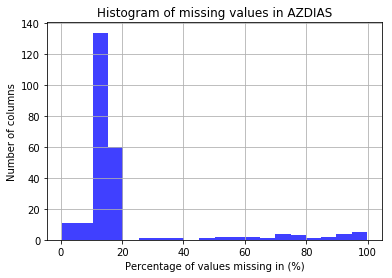

In [31]:
# Investigate patterns in the amount of missing data in each column for AZDIAS
plt.hist(missing_azdias[missing_azdias > 0]/(azdias.shape[0]) * 100, bins=20, facecolor='b', alpha=0.75)

plt.xlabel('Percentage of values missing in (%)')
plt.ylabel('Number of columns')
plt.title('Histogram of missing values in AZDIAS')
plt.grid(True)
plt.show()

From the above EDA it seems that majority of columns in azdias df are missing less than 20% of their values. I wonder if I see a different trend when I only look at the oultier columns

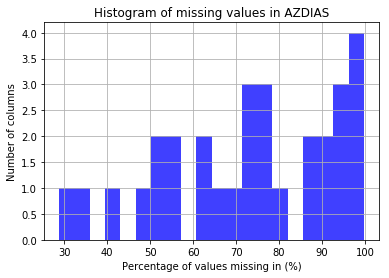

In [32]:
plt.hist(missing_azdias[outlier_cols_azdias][missing_azdias[outlier_cols_azdias] > 0]/(azdias[outlier_cols_azdias].shape[0]) * 100, bins=20, facecolor='b', alpha=0.75)

plt.xlabel('Percentage of values missing in (%)')
plt.ylabel('Number of columns')
plt.title('Histogram of missing values in AZDIAS')
plt.grid(True)
plt.show()

Above is the same EDA as before but now only looking at the columns that are missing more than a single standard deviation of missing data. It seems that 20% of missing data is a good place to cut in order to exclude columns.

In [33]:
col_names_azdias = azdias.columns

# list of columns in AZDIAS which missing more than 20% values:
az_outlier_cols_20p =[]
for col in col_names_azdias:
    if (azdias[col].isnull().sum()/azdias.shape[0])*100 > 20:
        az_outlier_cols_20p.append(col)
print(az_outlier_cols_20p)

['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'KBA05_BAUMAX', 'TITEL_KZ']


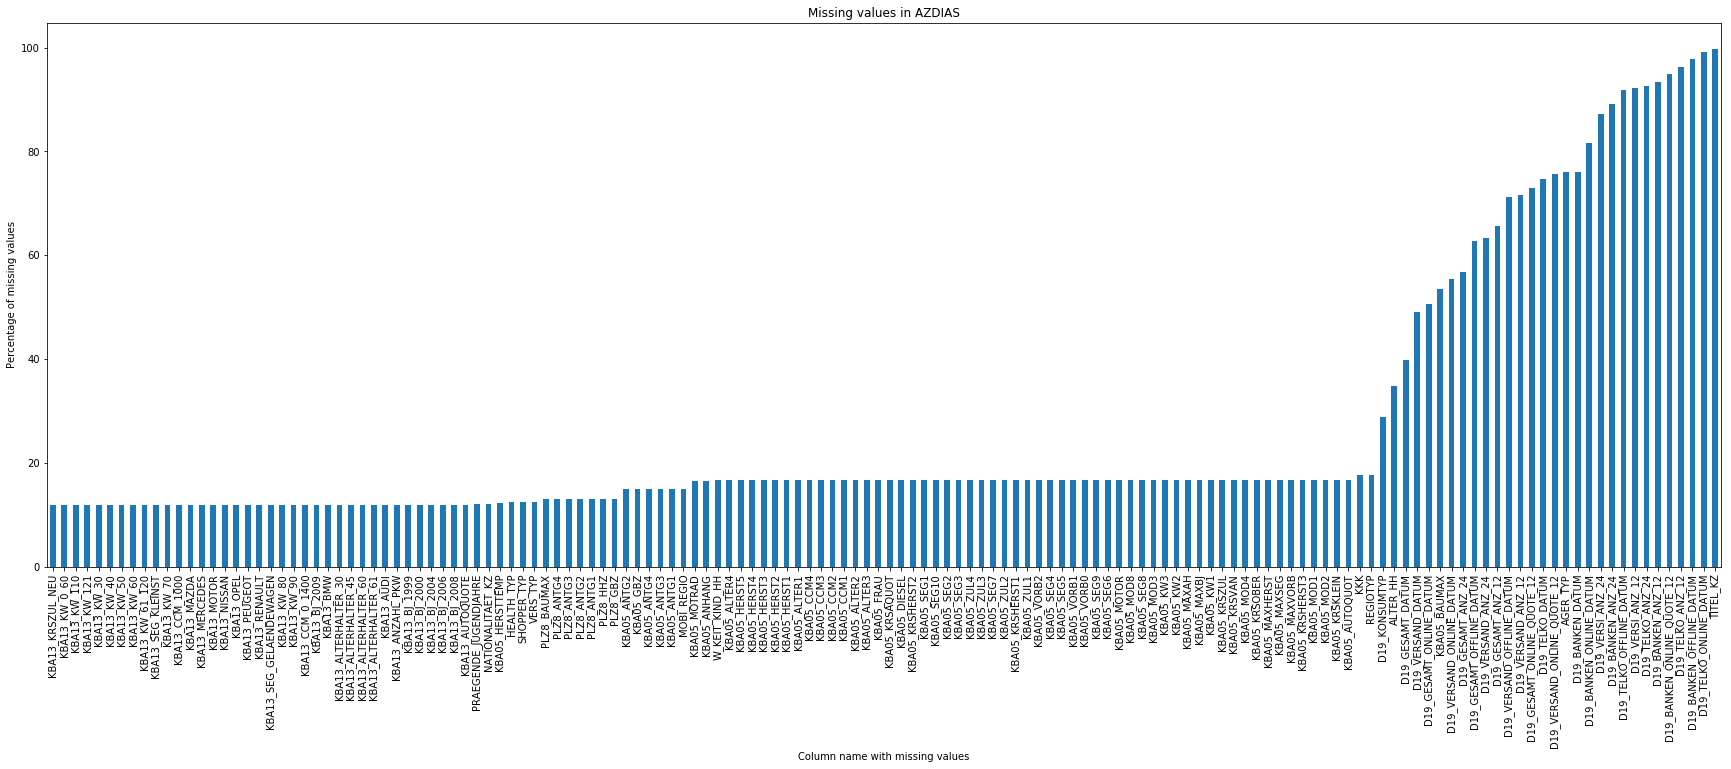

In [34]:
missing_sorted = missing_azdias[missing_azdias > 0]/(azdias.shape[0]) * 100
missing_sorted.sort_values(inplace=True)
missing_sorted[100:].plot.bar(figsize=(30,10))
plt.title('Missing values in AZDIAS')
plt.xlabel('Column name with missing values')
plt.ylabel('Percentage of missing values')

plt.show()

The above plot confirms my suspicion to drop the columns in the azdias df that are missing more than 20% of their data.

In [35]:
# Remove the outlier columns from the dataset.
#  I will define "outlier" columns as those who are missing more than 20% of data from azdias (and 30% from customers)

azdias.drop(az_outlier_cols_20p, axis='columns', inplace=True)
customers.drop(az_outlier_cols_20p, axis='columns', inplace=True)

In [36]:
## AFTER STEP TWO
azdias.shape, customers.shape

((891221, 242), (191652, 245))

#### Step 1.1.2: Assess Missing Data in Each Row <a class="anchor" id="part1.1.2"></a>

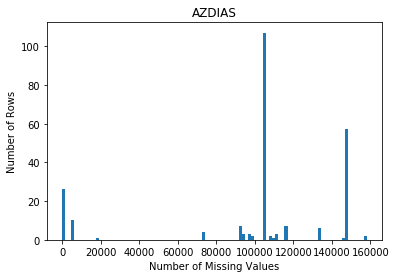

In [37]:
# How much data is missing in each row of the dataset?
az_missing_per_row = azdias.isnull().sum(axis='rows')
plt.hist(az_missing_per_row, bins=100)
plt.title('AZDIAS')
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [38]:
az_missing_per_row.describe()

count       242.000000
mean     100348.491736
std       46179.650387
min           0.000000
25%      105800.000000
50%      105800.000000
75%      133324.000000
max      158064.000000
dtype: float64

In [39]:
# drop rows that are missing more than 10 values values

azdias.drop(azdias[azdias.isnull().sum(axis=1)>10].index,axis=0,inplace=True)
customers.drop(customers[customers.isnull().sum(axis=1)>10].index,axis=0,inplace=True)

In [40]:
## AFTER STEP THREE
azdias.shape, customers.shape

((736521, 242), (135096, 245))

### Part 1.2: Select and Re-Encode Features <a class="anchor" id="part1.2"></a>

#### Part 1.2.1:  Re-Encode Features <a class="anchor" id="part1.2.1"></a>

In [41]:
azdias.dtypes.unique() 

array([dtype('float64'), dtype('O'), dtype('int64')], dtype=object)

In [42]:
azdias.select_dtypes(include='object').describe()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,OST_WEST_KZ
count,733502,733502,736521
unique,45,19,2
top,6B,8,W
freq,53960,74711,581642


In [43]:
customers.dtypes.unique() 

array([dtype('float64'), dtype('O'), dtype('int64')], dtype=object)

In [44]:
customers.select_dtypes(include='object').describe()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
count,134911,134911,135096,135096,135096
unique,45,19,2,3,2
top,2D,2,W,COSMETIC_AND_FOOD,MULTI_BUYER
freq,10875,16880,124341,72936,95193


In [45]:
# CAMEO_DEU_2015 has too many variables so we will drop them
# CAMEO_DEUG_2015 has an X and I do not know what it stands for so I will drop it as well
objects_to_drop = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015']

customers.drop(objects_to_drop, axis=1, inplace=True)
azdias.drop(objects_to_drop, axis=1, inplace=True)

In [46]:
# OHE customers[['PRODUCT_GROUP'], ['CUSTOMER_GROUP']]
customers = pd.concat([customers,pd.get_dummies(customers['PRODUCT_GROUP'], prefix='PRODUCT_GROUP',dummy_na=False)],axis=1).drop(['PRODUCT_GROUP'],axis=1)
customers = pd.concat([customers,pd.get_dummies(customers['CUSTOMER_GROUP'], prefix='CUSTOMER_GROUP',dummy_na=False)],axis=1).drop(['CUSTOMER_GROUP'],axis=1)                                           
                    

In [47]:
# change dtype to int
customers['PRODUCT_GROUP_COSMETIC']= customers['PRODUCT_GROUP_COSMETIC'].astype(int)
customers['PRODUCT_GROUP_COSMETIC_AND_FOOD']= customers['PRODUCT_GROUP_COSMETIC_AND_FOOD'].astype(int)
customers['PRODUCT_GROUP_FOOD']= customers['PRODUCT_GROUP_FOOD'].astype(int)

customers['CUSTOMER_GROUP_MULTI_BUYER']= customers['CUSTOMER_GROUP_MULTI_BUYER'].astype(int)
customers['CUSTOMER_GROUP_SINGLE_BUYER']= customers['CUSTOMER_GROUP_SINGLE_BUYER'].astype(int)


In [48]:
# re-encode 'OST_WEST_KZ'
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace({'O': 0, 
    'W': 1})
customers['OST_WEST_KZ'] = customers['OST_WEST_KZ'].replace({'O': 0, 
    'W': 1})

In [49]:
customers.dtypes.unique() # Great! They are all integers/floats now

array([dtype('float64'), dtype('int64')], dtype=object)

In [50]:
azdias.dtypes.unique() # Great! They are all integers/floats now

array([dtype('float64'), dtype('int64')], dtype=object)

#### Part 1.2.2: Create Cleaning Function <a class="anchor" id="part1.2.2"></a>

In [3]:
## RE-IMPORT AZDIAS

body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='ud-donotdelete-pr-p4an6ai60a86ev',Key='Udacity_AZDIAS.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

azdias_unclean = pd.read_csv(body)
del azdias_unclean['Unnamed: 0']

azdias_unclean.head()


/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
## RE-IMPORT CUSTOMERS

body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='ud-donotdelete-pr-p4an6ai60a86ev',Key='Udacity_CUSTOMERS.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

customers_unclean = pd.read_csv(body)
del customers_unclean['Unnamed: 0']

customers_unclean.head()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
## RE-IMPORT NAN_DF

body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='ud-donotdelete-pr-p4an6ai60a86ev',Key='nan_df.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

nan_df = pd.read_csv(body)
nan_df.head()


,column,nan_values
0,AGER_TYP,['-1']
1,AGER_TYP,['0']
2,ALTERSKATEGORIE_GROB,"['-1', ' 0']"
3,ALTER_HH,['0']
4,ANREDE_KZ,"['-1', ' 0']"


In [6]:
## RE-IMPORT FEAT_INFO

body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='ud-donotdelete-pr-p4an6ai60a86ev',Key='feat_info2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

feat_info = pd.read_csv(body)
feat_info.head()


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [7]:
nan_df['nan_values'] = nan_df['nan_values'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').split(','))

In [8]:
# Stored from earlier so I do not have to run the cells at the top of the notebook every time

undefined_features = ['LNR','AKT_DAT_KL','ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN','ANZ_KINDER','ANZ_STATISTISCHE_HAUSHALTE','ARBEIT','CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER','CJT_TYP_1','CJT_TYP_2','CJT_TYP_3','CJT_TYP_4','CJT_TYP_5','CJT_TYP_6',
 'D19_BANKEN_DIREKT','D19_BANKEN_GROSS','D19_BANKEN_LOKAL','D19_BANKEN_REST','D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST','D19_BILDUNG','D19_BIO_OEKO','D19_BUCH_CD','D19_DIGIT_SERV','D19_DROGERIEARTIKEL',
 'D19_ENERGIE','D19_FREIZEIT','D19_GARTEN','D19_HANDWERK','D19_HAUS_DEKO','D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX','D19_KOSMETIK','D19_LEBENSMITTEL','D19_LETZTER_KAUF_BRANCHE','D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG','D19_RATGEBER','D19_REISEN','D19_SAMMELARTIKEL','D19_SCHUHE',
 'D19_SONSTIGE','D19_SOZIALES','D19_TECHNIK','D19_TELKO_MOBILE','D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST','D19_TIERARTIKEL','D19_VERSAND_REST','D19_VERSI_DATUM','D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM','D19_VERSI_ONLINE_QUOTE_12','D19_VERSICHERUNGEN','D19_VOLLSORTIMENT',
 'D19_WEIN_FEINKOST','DSL_FLAG','EINGEFUEGT_AM','EINGEZOGENAM_HH_JAHR','EXTSEL992','FIRMENDICHTE',
 'GEMEINDETYP','HH_DELTA_FLAG','KBA13_ANTG1','KBA13_ANTG2','KBA13_ANTG3','KBA13_ANTG4','KBA13_BAUMAX',
 'KBA13_CCM_1401_2500','KBA13_GBZ','KBA13_HHZ','KBA13_KMH_210','KK_KUNDENTYP','KOMBIALTER',
 'KONSUMZELLE','MOBI_RASTER','RT_KEIN_ANREIZ','RT_SCHNAEPPCHEN','RT_UEBERGROESSE','SOHO_KZ',
 'STRUKTURTYP','UMFELD_ALT','UMFELD_JUNG','UNGLEICHENN_FLAG','VERDICHTUNGSRAUM','VHA','VHN',
 'VK_DHT4A','VK_DISTANZ','VK_ZG11']

In [9]:
# Stored from earlier so I do not have to run the cells at the top of the notebook every time

az_outlier_cols_20p = ['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 
                       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 
                       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 
                       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_TELKO_ANZ_12', 
                       'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 
                       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 
                       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 
                       'D19_VERSI_ANZ_24', 'KBA05_BAUMAX', 'TITEL_KZ']

In [10]:
decade_dict = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
               8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
               14: 6, 15: 6}

In [11]:
movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2}

In [12]:
azdias_unclean.shape

(891221, 366)

In [13]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    
    # replace unknowns
    df = change_to_nan(df)
    print('Replace unknowns, OK', df.shape)

    # remove selected columns
    df = drop_undefined_features(df)
    print('Drop undefined features, OK', df.shape)
    
    # remove selected columns
    df = drop_outlier_cols(df)
    print('Remove selected columns', df.shape)
    
    # remove selected rows
    df = drop_rows(df)
    print('Remove selected rows, OK', df.shape)
    
    df = reencode_cat(df)
    print('Re-encode categorical variables, OK', df.shape)
    
    df = engineer_mix(df)
    print('Engineer column value, OK', df.shape)
    
    # select, re-encode, and engineer column values.
    df = OHE(df)
    print('Select, re-encode column value, OK', df.shape)

    # Return the cleaned dataframe
    return df

## FIRST STEP IS REPLACE UNKNOWNS WITH NAN
def change_to_nan(df):
    for col in nan_df['column']:
        for i in nan_df.query('column == @col')['nan_values'].values[0]:
            if i not in ['XX','X','']:
                i=np.float64(i)
            if i == '':
                i = np.nan
            try:
                df.loc[df[col] == i, col] = np.nan
            except:
                pass
    return df


## SECOND STEP IS DROP UNDEFINED FEATURES
def drop_undefined_features(df):
    df.drop(undefined_features, axis='columns', inplace=True)
    
    return df

## THIRD STEP IS DROP OUTLIER COLS (missing more than 20% of data)
def drop_outlier_cols(df):
    
    for col in az_outlier_cols_20p:
        if col in df.columns:
            df.drop(col, axis='columns', inplace=True)
        else:
            pass
    
    return df

### FOURTH STEP IS DROP ROWS MISSING DATA
def drop_rows(df):
    #drop rows with more than 10 nas
    
    df.drop(df[df.isnull().sum(axis=1)>10].index,axis=0, inplace=True)
    
    return df

## FIFTH STEP IS RE-ENCODE CATEGORICAL FEATURES
def reencode_cat(df):
    
    # Drop the categorical features with too many features from the  df
    cat_to_drop = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015']
    df.drop(cat_to_drop, axis= 'columns', inplace = True)
    
    # Reencode the one binary variable that takes on non-numeric values
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0, 
    'W': 1})
    
    return df

## SIXTH STEP IS ENGINEER MIXED TYPE FEATURES
def engineer_mix(df):

    # Create two new variables from 'PRAEGENDE_JUGENDJAHRE'
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    # Drop the mixed columns
    df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace=True)
    
    return df

## SEVENTH STEP IS ONE HOT ENCODE FEATURES
def OHE(df):
    
    if 'PRODUCT_GROUP' in df.columns:

        # Create dummy variables for 'PRODUCT_GROUP' and 'CUSTOMER_GROUP'
        df = pd.concat([df,pd.get_dummies(df['PRODUCT_GROUP'], prefix='PRODUCT_GROUP',dummy_na=False)],axis=1).drop(['PRODUCT_GROUP'],axis=1)
        df = pd.concat([df,pd.get_dummies(df['CUSTOMER_GROUP'], prefix='CUSTOMER_GROUP',dummy_na=False)],axis=1).drop(['CUSTOMER_GROUP'],axis=1)
        
        df['PRODUCT_GROUP_COSMETIC']= df['PRODUCT_GROUP_COSMETIC'].astype(int)
        df['PRODUCT_GROUP_COSMETIC_AND_FOOD']= df['PRODUCT_GROUP_COSMETIC_AND_FOOD'].astype(int)
        df['PRODUCT_GROUP_FOOD']= df['PRODUCT_GROUP_FOOD'].astype(int)

        df['CUSTOMER_GROUP_MULTI_BUYER']= df['CUSTOMER_GROUP_MULTI_BUYER'].astype(int)
        df['CUSTOMER_GROUP_SINGLE_BUYER']= df['CUSTOMER_GROUP_SINGLE_BUYER'].astype(int)
        
        ohe_feats = ['PRODUCT_GROUP_COSMETIC', 'PRODUCT_GROUP_COSMETIC_AND_FOOD',
       'PRODUCT_GROUP_FOOD', 'CUSTOMER_GROUP_MULTI_BUYER',
       'CUSTOMER_GROUP_SINGLE_BUYER','ONLINE_PURCHASE']
        customers_ohe = df[ohe_feats]
        df.drop(columns=ohe_feats, axis= 0, inplace=True)
    
    else:
        exit
    
    return df

## Part 2: Customer Segmentation Report <a class="anchor" id="part2"></a>

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [14]:
azdias_clean = clean_data(azdias_unclean)
customers_clean = clean_data(customers_unclean)

Replace unknowns, OK (891221, 366)
Drop undefined features, OK (891221, 272)
Remove selected columns (891221, 242)
Remove selected rows, OK (736521, 242)
Re-encode categorical variables, OK (736521, 240)
Engineer column value, OK (736521, 241)
Select, re-encode column value, OK (736521, 241)
Replace unknowns, OK (191652, 369)
Drop undefined features, OK (191652, 275)
Remove selected columns (191652, 245)
Remove selected rows, OK (133982, 245)
Re-encode categorical variables, OK (133982, 243)
Engineer column value, OK (133982, 244)
Select, re-encode column value, OK (133982, 241)


In [15]:
#project.save_data(file_name = "azdias_clean.csv",data = azdias_clean.to_csv(index=False))

In [16]:
#project.save_data(file_name = "customers_clean.csv",data = customers_clean.to_csv(index=False))

### Part 2.0: Impute missing Values <a class="anchor" id="part2.0"></a>

In [15]:
# Impute the missing values using the mean

imp = Imputer(missing_values=np.nan , strategy= 'mean', axis=0)

azdias_impute = imp.fit_transform(azdias_clean) #this output should be an array
customers_impute = imp.fit_transform(customers_clean) #this output should be an array


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
azdias_impute.shape

(736521, 241)

### Part 2.1: Apply Feature Scaling  <a class="anchor" id="part2.1"></a>

#### Part 2.1.0: Fit with scaler <a class="anchor" id="part2.1.0"></a>

In [17]:
# Fit the Scaler without NaN 

scaler = StandardScaler()

azdias_no_nulls = azdias_clean.dropna(axis=0)

scaler.fit(azdias_no_nulls)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
# Apply feature scaling to AZDIAS data azdias
# transform data with the fitted scaler

azdias_scale = scaler.transform(azdias_impute) #output is array 
azdias_scale = pd.DataFrame(azdias_scale, columns=azdias_clean.columns) #turn array into df
azdias_scale.describe()


,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,...,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,DECADE,MOVEMENT
count,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000,...,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000,736521.000000
mean,0.001627,0.002880,-0.066952,-0.000206,0.016350,0.017802,-0.026947,0.052141,0.013569,-0.023939,...,0.000620,-0.008183,-0.001745,-0.004488,0.029535,0.000073,0.018772,0.023117,0.001135,-0.017633
std,1.011757,1.037454,1.033448,0.998223,0.996625,1.005451,1.006518,1.017916,1.011520,1.013480,...,0.972043,0.977341,0.976699,1.004023,1.011322,1.011234,0.999384,1.052352,0.993280,0.974733
min,-0.545952,-0.127709,-1.610507,-0.060759,-1.416405,-1.625132,-1.770149,-1.224703,-1.578663,-1.520336,...,-1.510358,-1.063172,-1.832129,-3.707210,-2.132381,-1.719930,-1.023711,-1.747382,-2.283155,-0.558422
25%,-0.412048,-0.127709,-0.722570,-0.060759,-0.960352,-0.967397,-1.181665,-1.224703,-0.846421,-0.786661,...,-0.542019,-1.063172,-0.683115,0.013918,-0.532516,-0.282872,-1.023711,-0.773635,-0.903359,-0.558422
50%,-0.278144,-0.127709,-0.722570,-0.060759,0.407808,0.348072,-0.004696,0.155427,-0.114179,-0.052986,...,0.000620,0.940581,-0.001745,0.545508,-0.532516,-0.282872,0.976838,0.200112,-0.213461,-0.558422
75%,0.056617,-0.127709,0.165368,-0.060759,0.863862,1.005807,1.172272,0.845492,0.618063,0.680689,...,0.426320,0.940581,1.040407,0.545508,0.534061,0.435657,0.976838,1.173859,1.166334,-0.017633
max,35.340352,66.524010,32.131114,58.505935,1.319915,1.663542,1.172272,1.535557,1.350305,1.414363,...,1.394659,0.940581,1.040407,0.545508,2.133926,1.872715,0.976838,6.042594,1.166334,1.790759


In [19]:
azdias_clean.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,...,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,DECADE,MOVEMENT
1,11.0,0.0,2.0,0.0,6.0,5.0,3.0,5.0,5.0,1.0,...,3.0,2.0,3.0,9.0,4.0,5.0,2.0,1.0,6.0,1.0
2,10.0,0.0,1.0,0.0,2.0,3.0,4.0,2.0,5.0,1.0,...,2.0,1.0,3.0,9.0,2.0,5.0,2.0,3.0,6.0,2.0
3,1.0,0.0,0.0,0.0,4.0,2.0,2.0,2.0,2.0,4.0,...,1.0,1.0,NaN,9.0,7.0,3.0,2.0,4.0,4.0,1.0
4,3.0,0.0,4.0,0.0,2.0,5.0,5.0,1.0,2.0,4.0,...,2.0,2.0,2.0,9.0,3.0,4.0,1.0,3.0,4.0,1.0
5,5.0,0.0,1.0,0.0,6.0,2.0,2.0,2.0,5.0,3.0,...,0.0,2.0,6.0,9.0,7.0,4.0,2.0,1.0,2.0,1.0


In [20]:
# Apply feature scaling to the CUSTOMERS data azdias
# transform data with the fitted scaler

customers_scale = scaler.transform(customers_impute) #output is array 
customers_scale = pd.DataFrame(customers_scale, columns=customers_clean.columns) #turn array into df
customers_scale.describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,...,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,DECADE,MOVEMENT
count,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000,...,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000,133982.000000
mean,-0.226647,0.086429,0.422725,0.241949,0.086627,-0.300905,-0.069947,-0.819065,-0.288946,0.882301,...,0.082663,-0.053373,0.058999,0.393258,-0.144532,-0.715544,-0.366861,0.695416,-1.004326,0.648608
std,0.918759,1.687670,1.242788,2.246015,0.964810,0.978265,0.943904,0.686147,0.953208,0.745402,...,1.128889,0.994008,1.045899,0.555652,1.101557,0.935636,0.939476,0.734413,0.914042,1.171559
min,-0.545952,-0.127709,-1.610507,-0.060759,-1.416405,-1.625132,-1.770149,-1.224703,-1.578663,-1.520336,...,-1.510358,-1.063172,-1.832129,-3.707210,-2.132381,-1.719930,-1.023711,-1.747382,-2.283155,-0.558422
25%,-0.479000,-0.127709,-0.722570,-0.060759,-0.960352,-0.967397,-1.181665,-1.224703,-0.846421,0.680689,...,-0.542019,-1.063172,-1.257622,0.545508,-1.065804,-1.719930,-1.023711,0.200112,-1.593257,-0.558422
50%,-0.479000,-0.127709,0.165368,-0.060759,0.407808,-0.309663,-0.004696,-1.224703,-0.846421,1.414363,...,0.426320,-0.053373,0.465900,0.545508,-0.532516,-0.282872,-1.023711,1.173859,-0.903359,1.790759
75%,-0.278144,-0.127709,1.053305,-0.060759,0.863862,0.348072,0.583788,-0.534638,0.618063,1.414363,...,1.394659,0.940581,1.040407,0.545508,0.534061,-0.282872,0.976838,1.173859,-0.213461,1.790759
max,34.469975,66.524010,17.036178,73.147608,1.319915,1.663542,1.172272,1.535557,1.350305,1.414363,...,1.394659,0.940581,1.040407,0.545508,2.133926,1.872715,0.976838,6.042594,1.166334,1.790759


#### Part 2.1.1: Perform Dimensionality Reduction <a class="anchor" id="part2.1.1"></a>

In [21]:
# Apply PCA to the AZDIAS data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scale)

In [22]:
# check components number should be the same as total features

components_total_az = len(pca.explained_variance_ratio_)

In [23]:
# generate sequence for plotting

components_az = np.arange(components_total_az)

Text(0.5, 1.0, 'Cumulative Explained Variance vs Number of Principal Components')

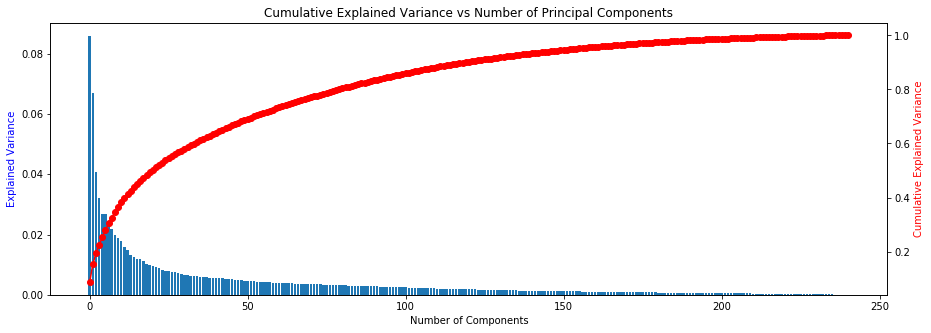

In [24]:
# Check out the ratio of variance explained by each principal component

fig, ax1 = plt.subplots(figsize=(15,5))
ax1.bar(components_az,pca.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')
ax2 = ax1.twinx() 
ax2.plot(np.cumsum(pca.explained_variance_ratio_), color="red",marker='o')
ax2.set_ylabel('Cumulative Explained Variance', color="red")
plt.title("Cumulative Explained Variance vs Number of Principal Components")

From above is seems that 150 is an appropriate number of components to suffieciently represent our data since they explain about 85%+ of our variance.

In [25]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_150 = PCA(n_components=150)
azdias_pca_150 = pca_150.fit_transform(azdias_scale) 

In [26]:
azdias_150 = pd.DataFrame(azdias_pca_150)

In [27]:
azdias_150.shape

(736521, 150)

In [29]:
def map_pca_weights_to_feats(pca, df, comp_no):
    '''Map pca weights to  individual features
    and return two pd.Series on with the highest
    positive weights and one with the lowest negative
    weights'''

    weights = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys())
    component = weights.iloc[comp_no - 1, :]
    comp_pos = component[component > 0].sort_values(ascending=False)
    comp_neg = component[component < 0].sort_values(ascending=True)

    return comp_pos[0:5], comp_neg[0:5];
    print(comp_pos[0:5])

In [29]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pca_weights_to_feats(pca, azdias_no_nulls, 1)

(MOBI_REGIO        0.1540
 PLZ8_ANTG1        0.1478
 KBA05_ANTG1       0.1466
 LP_STATUS_GROB    0.1454
 LP_STATUS_FEIN    0.1445
 Name: 0, dtype: float64, HH_EINKOMMEN_SCORE   -0.1579
 PLZ8_ANTG3           -0.1427
 PLZ8_ANTG4           -0.1369
 PLZ8_BAUMAX          -0.1362
 KBA13_HALTER_30      -0.1171
 Name: 0, dtype: float64)

**Most positive weights of first principal component:**
- MOBI_REGIO: moving patterns
   - (1: very high mobility, 5: very low mobility)
- PLZ8_ANTG1: number of 1-2 family houses in the PLZ8
   - (0: none, 4: very high share)	
- KBA05_ANTG1: number of 1-2 family houses in the cell
   - (0: no 1-2 family homes, 4: very high share of 1-2 family homes)
- LP_STATUS_GROB: social status rough
   - (1: low-income earners, 10: top earners)
- LP_STATUS_FEIN: social status fine
   - ((1: typical low-income earners, 10: top earners)
    
**Most negative weights of first principal component:**
- HH_EINKOMMEN_SCORE: economic score
    - (1: highest income, 6: very low income)
- PLZ8_ANTG3: number of 6-10 family houses in the PLZ8
   - (0: none, 3: high share)
- PLZ8_ANTG4: number of >10 family houses in the PLZ8
   - (0: none, 3: high share)
- PLZ8_BAUMAX: most common building-type within the PLZ8
   - (1: mainly 1-2 family homes, 4: mainly >10 family homes)
- KBA13_HALTER_30: share of car owners below 31 within the PLZ8
   - (0: none, 3: high share)
    
Principal component 1 seems to be about income and home ownership.

In [54]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pca_weights_to_feats(pca, azdias_no_nulls, 2)

(KBA13_HERST_BMW_BENZ           0.1753
 EWDICHTE                       0.1595
 KBA13_SEG_OBEREMITTELKLASSE    0.1543
 KBA13_BMW                      0.1503
 ORTSGR_KLS9                    0.1466
 Name: 1, dtype: float64, KBA13_ALTERHALTER_60   -0.1494
 KBA13_HALTER_20        -0.1369
 KBA13_SITZE_5          -0.1364
 KBA13_HALTER_55        -0.1339
 KBA13_HALTER_50        -0.1316
 Name: 1, dtype: float64)

**Most positive weights of second principal component:**
- KBA13_HERST_BMW_BENZ: share of BMW & Mercedes Benz within the PLZ8
    - (0: none, 5: very high)
- EWDICHTE: density of inhabitants per square kilometer
    - (1: less than 34 HH/km², 6: more than 999 HH/²)
- KBA13_SEG_OBEREMITTELKLASSE: share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
    - (0: none, 5: very high)
- KBA13_BMW: share of BMW within the PLZ8
    - (0: none, 5: very high)
- ORTSGR_KLS9: classified number of inhabitants
    -  (1: <= 2.000 inhabitants, 9: > 700.000 inhabitants)
    
**Most negative weights of second principal component:**
- KBA13_ALTERHALTER_60: share of car owners between 46 and 60 within the PLZ8
    - (0: none, 5: very high)
- KBA13_HALTER_20: share of car owners below 21 within the PLZ8
    - (0: none, 4: very high)
- KBA13_SITZE_5: number of cars with 5 seats in the PLZ8
    - (0: none, 4: very high)
- KBA13_HALTER_55: share of car owners between 51 and 55 within the PLZ8
    - (0: none, 4: very high)
- KBA13_HALTER_50: share of car owners between 46 and 50 within the PLZ8
    - (0: none, 4: very high)

Principal component 2 seems to be about income and car ownership.

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pca_weights_to_feats(pca, azdias_no_nulls, 3)

(ALTERSKATEGORIE_GROB    0.2360
 FINANZ_VORSORGER        0.2043
 SEMIO_ERL               0.1847
 SEMIO_LUST              0.1651
 RETOURTYP_BK_S          0.1446
 Name: 2, dtype: float64, FINANZ_SPARER           -0.2447
 DECADE                  -0.2355
 SEMIO_REL               -0.2336
 SEMIO_PFLICHT           -0.2253
 FINANZ_UNAUFFAELLIGER   -0.2162
 Name: 2, dtype: float64)

**Most positive weights of third principal component:**
- ALTERSKATEGORIE_GROB: age through prename analysis
    - (1: < 30 years, 4: > 60 years)
- FINANZ_VORSORGER: financial typology: be prepared
    - (1: very high, 5: very low)
- SEMIO_ERL: affinity indicating in what way the person is eventful orientated
    - (1: highest affinity, 7: lowest affinity) 
- SEMIO_LUST: affinity indicating in what way the person is sensual minded
    - (1: highest affinity, 7: lowest affinity) 
- RETOURTYP_BK_S: return type
    - (1: influenceable Crazy-Shopper, 5: determined Minimal-Returne)

**Most negative weights of third principal component:**

- FINANZ_SPARER: financial typology: money saver
    - ((1: very high, 5: very low)
- DECADE: Decade someone was born
    - (1: 40s, 15: 90s)
- SEMIO_REL: affinity indicating in what way the person is religious
    - (1: highest affinity, 7: lowest affinity) 
- SEMIO_PFLICHT: affinity indicating in what way the person is dutyfull traditional minded
    - (1: highest affinity, 7: lowest affinity) 
- FINANZ_UNAUFFAELLIGER: financial typology: unremarkable
    -  (1: very high, 5: very low)


Principal component 3 encompasses age and financial typology.

### Part: 2.2: Clustering   <a class="anchor" id="part2.2"></a>

In [28]:
# Over a number of different cluster counts...
## FROM UDACITY NOTEBOOK

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''

    # run k-means clustering on the data .
    kmeans = KMeans(n_clusters=center)
    
    # fit the model
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score
    

#### Part 2.2.0: Apply Clustering to General Population <a class="anchor" id="part2.2.0"></a>

In [29]:
## TRY THIS ONE

# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

start_time = time.time()

scores = []
centers = list(range(1,30,2))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca_150, center))
    
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

--- Run time: 196.01 mins ---


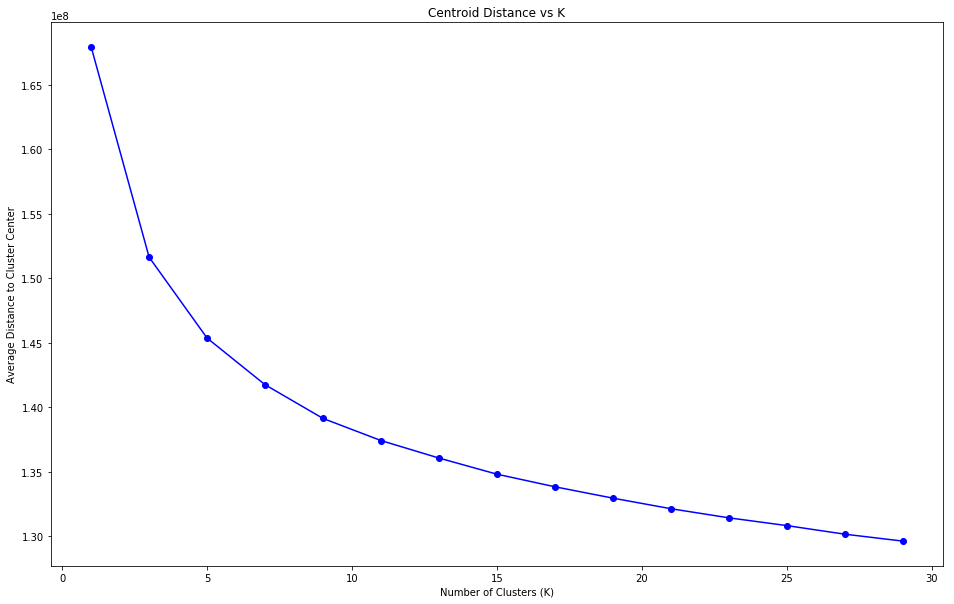

In [30]:
# Plot relationship plot

fig, ax = plt.subplots(figsize=(16,10))    
plt.plot(centers, scores, marker='o', color='b');
ax.set_xlabel("Number of Clusters (K)")
ax.set_ylabel("Average Distance to Cluster Center");
plt.title('Centroid Distance vs K');


In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# general population demographics data: df (as dataframe), df_pca (as array)


In [31]:
n_clusters_az = 15

In [32]:
start_time = time.time()
kmeans = KMeans(n_clusters=15)
#model_az = kmeans_az.fit(azdias_pca)
model_az = kmeans.fit(azdias_pca_150)
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

--- Run time: 12.79 mins ---


In [33]:
predict_general = model_az.predict(azdias_pca_150)

In [34]:
predict_general

array([ 3,  8, 11, ...,  2,  1,  8], dtype=int32)

#### Part 2.2.1: Apply Clustering to Customers population <a class="anchor" id="part2.2.1"></a>

In [35]:
# Perform PCA on the customers dataset using the pca generated using azdias

customers_pca_150 = pca_150.transform(customers_scale)

In [36]:
# Perform clustering on customers dataset using model generated using azdias

predict_customers = model_az.predict(customers_pca_150)

In [37]:
predict_customers

array([11,  5, 11, ...,  5, 13, 11], dtype=int32)

In [38]:
len(predict_general), len(predict_customers)

(736521, 133982)

## Step 2.3: Compare Customer Data to Demographics Data  <a class="anchor" id="part2.3"></a>

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [39]:
predict_customers = pd.Series(predict_customers)
p_c = predict_customers.value_counts().sort_index()
p_c = pd.Series(p_c)
p_c

0      5677
1       495
2      1116
3      1850
4      2404
5     40751
6      2329
7      2106
8     10884
9      2703
10    22152
11    20270
12     1856
13     8467
14    10922
dtype: int64

In [40]:
predict_general = pd.Series(predict_general)
p_g = predict_general.value_counts().sort_index()
p_g = pd.Series(p_g)
p_g

0     34404
1     47958
2     58256
3     42999
4     29250
5     73699
6     37111
7     46180
8     63773
9     42424
10    46047
11    62507
12    44803
13    54961
14    52149
dtype: int64

In [41]:
joint_df = pd.concat([p_g, p_c], axis=1).reset_index()
joint_df.columns = ['cluster','population','customers']
joint_df

,cluster,population,customers
0,0,34404,5677
1,1,47958,495
2,2,58256,1116
3,3,42999,1850
4,4,29250,2404
5,5,73699,40751
6,6,37111,2329
7,7,46180,2106
8,8,63773,10884
9,9,42424,2703


In [42]:
#Population and customer percentage of total per cluster.

joint_df['pop_prop'] = (joint_df['population']/joint_df['population'].sum()*100).round(2)
joint_df['cust_prop'] = (joint_df['customers']/joint_df['customers'].sum()*100).round(2)

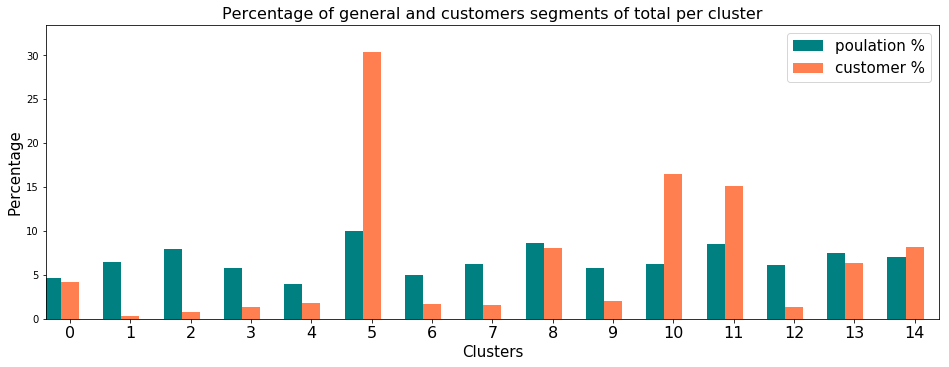

In [51]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)

ax = joint_df['pop_prop'].plot(x=joint_df['cluster'], kind='bar',color='teal',width=-0.3, align='edge',position=0)
ax = joint_df['cust_prop'].plot(kind='bar',color='coral',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Percentage', fontsize=15)
ax.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Percentage of general and customers segments of total per cluster')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.show()

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

In [52]:
over = scaler.inverse_transform(pca_150.inverse_transform(customers_pca_150[np.where(predict_customers==5)])).round()
df_over = pd.DataFrame(data = over, columns = customers_clean.columns)
#df_over.head(10)

In [53]:
df_over_desc = df_over.describe().T

The demographic of people overrepresented in the customer data 

- ANZ_HAUSHALTE_AKTIV is low
- BALLRAUM is 4
- SEMIO_FAM is 4
- SEMIO_KULT is 4
- SEMIO_PFLICHT 2.7
- SEMIO_REL 3.1


In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [54]:
under = scaler.inverse_transform(pca_150.inverse_transform(customers_pca_150[np.where(predict_customers==2)])).round()
df_under = pd.DataFrame(data=under, columns=customers_clean.columns)
#df_under.head(10)

In [55]:
df_under_desc = df_under.describe().T

In [62]:
for rows in df_over_desc.index:
    over_mean = df_over_desc.loc[rows,'mean']
    under_mean = df_under_desc.loc[rows,'mean']
    if over_mean-under_mean >=2:
        print(rows)
    

FINANZ_MINIMALIST
FINANZ_VORSORGER
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
SEMIO_LUST
SEMIO_VERT


In [58]:
for rows in df_over_desc.index:
    over_mean = df_over_desc.loc[rows,'mean']
    under_mean = df_under_desc.loc[rows,'mean']
    if under_mean-over_mean >=3:
        print(rows)

GEBURTSJAHR
KBA13_ANZAHL_PKW
SEMIO_RAT


In [70]:
df_over_desc[1:50]

,count,mean,std,min,25%,50%,75%,max
ANZ_HH_TITEL,40751.0,0.023190,0.153893,0.0,0.0,0.0,0.0,3.0
ANZ_PERSONEN,40751.0,2.662610,1.331655,-1.0,2.0,3.0,4.0,13.0
ANZ_TITEL,40751.0,0.021104,0.153635,-0.0,0.0,-0.0,0.0,3.0
BALLRAUM,40751.0,4.285294,1.941091,0.0,2.0,5.0,6.0,8.0
CJT_GESAMTTYP,40751.0,3.014797,1.455753,0.0,2.0,3.0,4.0,6.0
EWDICHTE,40751.0,4.045128,1.026328,1.0,3.0,4.0,5.0,7.0
FINANZ_ANLEGER,40751.0,1.299575,0.759056,0.0,1.0,1.0,2.0,6.0
FINANZ_HAUSBAUER,40751.0,2.264165,0.890513,0.0,2.0,2.0,3.0,6.0
FINANZ_MINIMALIST,40751.0,4.825010,0.548845,1.0,5.0,5.0,5.0,6.0
FINANZ_SPARER,40751.0,1.214105,0.603648,0.0,1.0,1.0,1.0,5.0


**Demographich of those overrepresented in the customers**
- GEBURTSJAHR 1285.064146	
  - year of birth (younger than those underrepresented)
- KBA13_ANZAHL_PKW 703.325342
  - number of cars in the PLZ8 (fewer cars)
- SEMIO_RAT 2.656597
  - affinity indicating in what way the person is of a rational mind (very high affinity)

- LP_LEBENSPHASE_FEIN 28.6
  - lifestage fine (top earner-families)
- LP_STATUS_FEIN 9.11	
  - social status fine (houseowners)
- SEMIO_VERT 5.58
  - affinity indicating in what way the person is dreamily (low-very low affinity)
  
- FINANZ_MINIMALIST 4.825010
   - financial typology: low financial interest (very low)
- FINANZ_VORSORGER 4.778116	
   - inancial typology: be prepared	(very low)
- LP_LEBENSPHASE_FEIN 28.6
   - lifestage fine (top earner-families)
- LP_LEBENSPHASE_GROB 3.559864
   - lifestage rough (single high-income earners)
- LP_STATUS_FEIN 9.115678	
   - social status fine (houseowners)
- LP_STATUS_GROB 8.429
   - social status rough (houseowners)
- SEMIO_LUST 5.736006
SEMIO_VERT 5.583495


**Demographich of those underrepresented in the customers**

- GEBURTSJAHR 1526.291219
  - year of birth (older than those overrepresented)
- KBA13_ANZAHL_PKW 	781.584229
  - number of cars in the PLZ8 (more cars)
- SEMIO_RAT 5.630542
  - affinity indicating in what way the person is of a rational mind (very low affinity)
  
- LP_LEBENSPHASE_FEIN 18.261649
  - lifestage fine (wealthy homeowner-couples of younger age)
- LP_STATUS_FEIN 5.085125	
  - social status fine (minimalistic high-income earners)
- SEMIO_VERT 2.581541
  - affinity indicating in what way the person is dreamily (very high affinity)
  
- FINANZ_MINIMALIST 2.360215
   - financial typology: low financial interest (high)
- FINANZ_VORSORGER 2.674731
   - inancial typology: be prepared	
- LP_LEBENSPHASE_FEIN 18
   - lifestage fine (wealthy homeowner-couples of younger age)
- LP_LEBENSPHASE_GROB 5.599462
   - lifestage rough (single parents)
- LP_STATUS_FEIN 5.085125	
   - social status fine (minimalistic high-income earners)
- LP_STATUS_GROB 2.464158	
   - social status rough (low-income - average earners)
- SEMIO_LUST 3.620072
- SEMIO_VERT 2.581541

  

  
**INSIGHT:** Customers tend to be high earners and high spenders with little financial interest (not necessarily savers). They have tend to be younger. They have a low affinity for being dreamily minded anbd a high affinity for being traditional and rationally minded.

## Part 3: Supervised Learning Model <a class="anchor" id="part3"></a>

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Part 3.0: Re-import<a class="anchor" id="part3.0"></a>

In [3]:
# import nan_df
body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='ud-donotdelete-pr-p4an6ai60a86ev',Key='nan_df.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

nan_df = pd.read_csv(body)
nan_df.head()


,column,nan_values
0,AGER_TYP,['-1']
1,AGER_TYP,['0']
2,ALTERSKATEGORIE_GROB,"['-1', ' 0']"
3,ALTER_HH,['0']
4,ANREDE_KZ,"['-1', ' 0']"


In [4]:
# import Udacity_MAILOUT_052018_TRAIN.csv: 
  # Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns)
    
body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='ud-donotdelete-pr-p4an6ai60a86ev',Key='Udacity_TRAIN.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

train = pd.read_csv(body)
del train['Unnamed: 0']
train.head()


/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [5]:
nan_df['nan_values'] = nan_df['nan_values'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').split(','))

# Stored from earlier so I do not have to run the cells at the top of the notebook every time

undefined_features = ['LNR','AKT_DAT_KL','ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN','ANZ_KINDER','ANZ_STATISTISCHE_HAUSHALTE','ARBEIT','CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER','CJT_TYP_1','CJT_TYP_2','CJT_TYP_3','CJT_TYP_4','CJT_TYP_5','CJT_TYP_6',
 'D19_BANKEN_DIREKT','D19_BANKEN_GROSS','D19_BANKEN_LOKAL','D19_BANKEN_REST','D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST','D19_BILDUNG','D19_BIO_OEKO','D19_BUCH_CD','D19_DIGIT_SERV','D19_DROGERIEARTIKEL',
 'D19_ENERGIE','D19_FREIZEIT','D19_GARTEN','D19_HANDWERK','D19_HAUS_DEKO','D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX','D19_KOSMETIK','D19_LEBENSMITTEL','D19_LETZTER_KAUF_BRANCHE','D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG','D19_RATGEBER','D19_REISEN','D19_SAMMELARTIKEL','D19_SCHUHE',
 'D19_SONSTIGE','D19_SOZIALES','D19_TECHNIK','D19_TELKO_MOBILE','D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST','D19_TIERARTIKEL','D19_VERSAND_REST','D19_VERSI_DATUM','D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM','D19_VERSI_ONLINE_QUOTE_12','D19_VERSICHERUNGEN','D19_VOLLSORTIMENT',
 'D19_WEIN_FEINKOST','DSL_FLAG','EINGEFUEGT_AM','EINGEZOGENAM_HH_JAHR','EXTSEL992','FIRMENDICHTE',
 'GEMEINDETYP','HH_DELTA_FLAG','KBA13_ANTG1','KBA13_ANTG2','KBA13_ANTG3','KBA13_ANTG4','KBA13_BAUMAX',
 'KBA13_CCM_1401_2500','KBA13_GBZ','KBA13_HHZ','KBA13_KMH_210','KK_KUNDENTYP','KOMBIALTER',
 'KONSUMZELLE','MOBI_RASTER','RT_KEIN_ANREIZ','RT_SCHNAEPPCHEN','RT_UEBERGROESSE','SOHO_KZ',
 'STRUKTURTYP','UMFELD_ALT','UMFELD_JUNG','UNGLEICHENN_FLAG','VERDICHTUNGSRAUM','VHA','VHN',
 'VK_DHT4A','VK_DISTANZ','VK_ZG11']

# Stored from earlier so I do not have to run the cells at the top of the notebook every time

az_outlier_cols_20p = ['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 
                       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 
                       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 
                       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_TELKO_ANZ_12', 
                       'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 
                       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 
                       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 
                       'D19_VERSI_ANZ_24', 'KBA05_BAUMAX', 'TITEL_KZ']

decade_dict = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
               8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
               14: 6, 15: 6}

movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2}

In [6]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    
    # replace unknowns
    df = change_to_nan(df)
    print('Replace unknowns, OK', df.shape)

    # remove selected columns
    df = drop_undefined_features(df)
    print('Drop undefined features, OK', df.shape)
    
    # remove selected columns
    df = drop_outlier_cols(df)
    print('Remove selected columns', df.shape)
    
    # remove selected rows
    df = drop_rows(df)
    print('Remove selected rows, OK', df.shape)
    
    df = reencode_cat(df)
    print('Re-encode categorical variables, OK', df.shape)
    
    df = engineer_mix(df)
    print('Engineer column value, OK', df.shape)
    
    # select, re-encode, and engineer column values.
    df = OHE(df)
    print('Select, re-encode column value, OK', df.shape)

    # Return the cleaned dataframe
    return df

## FIRST STEP IS REPLACE UNKNOWNS WITH NAN
def change_to_nan(df):
    for col in nan_df['column']:
        for i in nan_df.query('column == @col')['nan_values'].values[0]:
            if i not in ['XX','X','']:
                i=np.float64(i)
            if i == '':
                i = np.nan
            try:
                df.loc[df[col] == i, col] = np.nan
            except:
                pass
    return df


## SECOND STEP IS DROP UNDEFINED FEATURES
def drop_undefined_features(df):
    df.drop(undefined_features, axis='columns', inplace=True)
    
    return df

## THIRD STEP IS DROP OUTLIER COLS (missing more than 20% of data)
def drop_outlier_cols(df):
    
    for col in az_outlier_cols_20p:
        if col in df.columns:
            df.drop(col, axis='columns', inplace=True)
        else:
            pass
    
    return df

### FOURTH STEP IS DROP ROWS MISSING DATA
def drop_rows(df):
    #drop rows with more than 10 nas
    
    df.drop(df[df.isnull().sum(axis=1)>10].index,axis=0, inplace=True)
    
    return df

## FIFTH STEP IS RE-ENCODE CATEGORICAL FEATURES
def reencode_cat(df):
    
    # Drop the categorical features with too many features from the  df
    cat_to_drop = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015']
    df.drop(cat_to_drop, axis= 'columns', inplace = True)
    
    # Reencode the one binary variable that takes on non-numeric values
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0, 
    'W': 1})
    
    return df

## SIXTH STEP IS ENGINEER MIXED TYPE FEATURES
def engineer_mix(df):

    # Create two new variables from 'PRAEGENDE_JUGENDJAHRE'
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    # Drop the mixed columns
    df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace=True)
    
    return df

## SEVENTH STEP IS ONE HOT ENCODE FEATURES
def OHE(df):
    
    if 'PRODUCT_GROUP' in df.columns:

        # Create dummy variables for 'PRODUCT_GROUP' and 'CUSTOMER_GROUP'
        df = pd.concat([df,pd.get_dummies(df['PRODUCT_GROUP'], prefix='PRODUCT_GROUP',dummy_na=False)],axis=1).drop(['PRODUCT_GROUP'],axis=1)
        df = pd.concat([df,pd.get_dummies(df['CUSTOMER_GROUP'], prefix='CUSTOMER_GROUP',dummy_na=False)],axis=1).drop(['CUSTOMER_GROUP'],axis=1)
        
        df['PRODUCT_GROUP_COSMETIC']= df['PRODUCT_GROUP_COSMETIC'].astype(int)
        df['PRODUCT_GROUP_COSMETIC_AND_FOOD']= df['PRODUCT_GROUP_COSMETIC_AND_FOOD'].astype(int)
        df['PRODUCT_GROUP_FOOD']= df['PRODUCT_GROUP_FOOD'].astype(int)

        df['CUSTOMER_GROUP_MULTI_BUYER']= df['CUSTOMER_GROUP_MULTI_BUYER'].astype(int)
        df['CUSTOMER_GROUP_SINGLE_BUYER']= df['CUSTOMER_GROUP_SINGLE_BUYER'].astype(int)
        
        ohe_feats = ['PRODUCT_GROUP_COSMETIC', 'PRODUCT_GROUP_COSMETIC_AND_FOOD',
       'PRODUCT_GROUP_FOOD', 'CUSTOMER_GROUP_MULTI_BUYER',
       'CUSTOMER_GROUP_SINGLE_BUYER','ONLINE_PURCHASE']
        customers_ohe = df[ohe_feats]
        df.drop(columns=ohe_feats, axis= 0, inplace=True)
    
    else:
        exit
    
    return df

In [7]:
# Clean the training data

train = clean_data(train)
#train.head()

Replace unknowns, OK (42962, 367)
Drop undefined features, OK (42962, 273)
Remove selected columns (42962, 243)
Remove selected rows, OK (33781, 243)
Re-encode categorical variables, OK (33781, 241)
Engineer column value, OK (33781, 242)
Select, re-encode column value, OK (33781, 242)


In [8]:
# Define the labels (y) to be the response column, and the rest of the columns to be X

y = pd.DataFrame(train['RESPONSE'])
X = train.drop(['RESPONSE'],1)
y.shape, X.shape

((33781, 1), (33781, 241))

### Part 3.1: Model Selection<a class="anchor" id="part3.1"></a>

In [9]:
# Obtain the vale counts for the response column

y['RESPONSE'].value_counts()

0    33365
1      416
Name: RESPONSE, dtype: int64

Only 1.2% of people responded. Since this data is so skewed we cannot simply look at accuracy (becuase it will not indicate whether we are flagging everyone as responding (99%+ accuracy). In our case a false negative is more detremental to our business outcome becuase we want to identify who will likely become a customer and we do not want to miss anyone. Thus our model needs to be a high recall model (out of the points that are labeled positive, how many of them are correctly predicted as positive?)

F1 score takes the average of precision and recall, and we care less about precision so this isn't a good metric with which to evaluate our model.

We want a higher F-beta (beta=2) so that it skews our F-score more towards recall (lower beta would skew towards precision)

In [10]:
# Print first few responses to ensure they are in an expected form

y.head()

,RESPONSE
0,0
1,0
2,0
3,0
4,0


In [11]:
# Perform imputation on train df

imputer = Imputer()
X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
X.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,...,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,DECADE,MOVEMENT
0,15.0,0.000000,1.0,0.0,5.0,2.0,5.0,2.0,5.0,3.0,...,3.0,2.0,6.000000,9.0,3.0,3.0,2.0,4.0,1.0,1.0
1,1.0,0.000000,2.0,0.0,5.0,2.0,1.0,2.0,3.0,5.0,...,2.0,1.0,4.000000,9.0,7.0,1.0,2.0,3.0,4.0,1.0
2,0.0,0.047665,0.0,0.0,1.0,4.0,6.0,1.0,2.0,5.0,...,3.0,1.0,4.608446,9.0,2.0,3.0,1.0,4.0,1.0,2.0
3,4.0,0.000000,2.0,0.0,2.0,2.0,6.0,1.0,5.0,4.0,...,1.0,2.0,6.000000,9.0,1.0,3.0,2.0,4.0,1.0,2.0
4,53.0,0.000000,1.0,0.0,4.0,6.0,5.0,1.0,5.0,3.0,...,1.0,1.0,6.000000,9.0,3.0,3.0,1.0,3.0,2.0,1.0


In [12]:
# Apply feature scaling to the train df
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,...,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,DECADE,MOVEMENT
0,0.570795,-1.301153e-01,-0.757468,-0.091245,0.336882,-0.583357,0.700398,0.131481,1.219344,-0.767237,...,1.088184,1.023904,8.177777e-01,0.245963,-0.522107,0.208579,0.855676,0.586486,-1.317773,-0.738957
1,-0.372391,-1.301153e-01,-0.024539,-0.091245,0.336882,-0.583357,-1.611744,0.131481,-0.219505,0.985876,...,0.206833,-0.987824,-3.575668e-01,0.245963,1.450195,-1.427557,0.855676,-0.650686,0.885399,-0.738957
2,-0.439762,-1.894180e-17,-1.490398,-0.091245,-1.487357,0.742221,1.278433,-0.763992,-0.938930,0.985876,...,1.088184,-0.987824,5.219578e-16,0.245963,-1.015183,0.208579,-1.168667,0.586486,-1.317773,1.360346
3,-0.170280,-1.301153e-01,-0.024539,-0.091245,-1.031297,-0.583357,1.278433,-0.763992,1.219344,0.109320,...,-0.674517,1.023904,8.177777e-01,0.245963,-1.508258,0.208579,0.855676,0.586486,-1.317773,1.360346
4,3.130871,-1.301153e-01,-0.757468,-0.091245,-0.119178,2.067799,0.700398,-0.763992,1.219344,-0.767237,...,-0.674517,-0.987824,8.177777e-01,0.245963,-0.522107,0.208579,-1.168667,-0.650686,-0.583382,-0.738957


In [13]:
X = np.array(X)
y = np.array(y)

In [14]:
y = y.ravel()

In [15]:
# df_scores.groupby('alg_name')['roc'].mean()

In [16]:
def find_model(X, y, learners):
    #finding the model by plotting the learning curves

    plt.figure(figsize=(18,5))
    
    #configure cross validation
    cross_validation = KFold(n_splits=5, random_state=42, shuffle=False)
    sample_sizes = []
    
    #configure steps 10% - 100%
    for i in range(10,110,10):
        sample_sizes.append(int((X.shape[0]/100) * i))

    counter = 1
    
    #for each model
    for l in learners:
        print(l.__class__.__name__)
        
        #arrays for the plot
        cv_score = []
        train_score = []
        
        # configure the plot
        plt.subplot(1, len(learners), counter)
        plt.title(l.__class__.__name__)
        plt.grid()
        counter+=1
        
        #for each step
        for s in sample_sizes:
            print(s)
            
            #arrays for the step results
            sample_cv_score = []
            sample_train_score = []
            
            #5 fold cv
            for train_index, test_index in cross_validation.split(X[:s]):
                X_train2, X_test2, y_train2, y_test2 = X[train_index],X[test_index],y[train_index], y[test_index]
                y_train2 = y_train2.reshape(len(y_train2))
                y_test2 = y_test2.reshape(len(y_test2))
                
                #fit the model
                l = l.fit(X_train2, y_train2)
                
                #predict with the trained model and pull the roc score
                sample_train_score.append(roc_auc_score(y_train2, l.predict_proba(X_train2)[:,1]))
                sample_cv_score.append(roc_auc_score(y_test2, l.predict_proba(X_test2)[:,1]))

            
            #pull the middled score over all folds 
            cv_score.append(np.array(sample_cv_score).mean())
            train_score.append(np.array(sample_train_score).mean())
            
            #print(cv_score)
            #print(train_score)
            
        #to see the progress and only the plot at the end 
        clear_output()
        
        plt.xticks(range(10,110,10))
        plt.xlabel('Sample size %')
        plt.ylabel('ROC Score')
        
        sns.lineplot(range(10,110,10), cv_score, label = 'Cross validation score',markers=["o"])
        sns.lineplot(range(10,110,10), train_score, label = 'Train score',markers=["o"])
        
        
    plt.show();

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

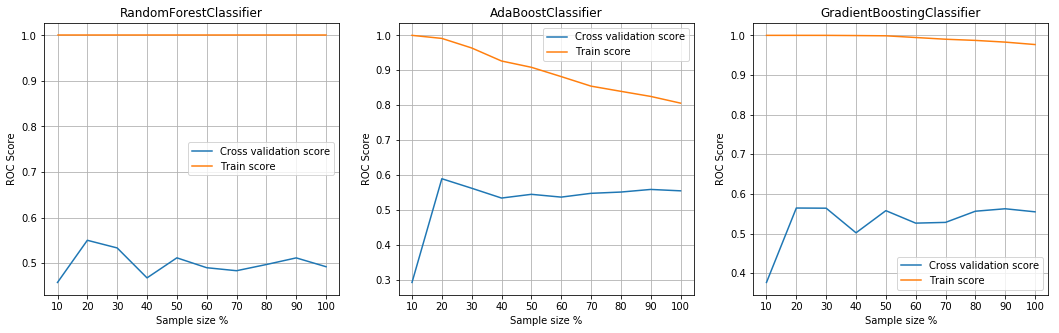

In [18]:

#re init the models
clf_A = RandomForestClassifier(random_state=0, n_estimators = 100)
clf_B = AdaBoostClassifier(random_state=0)
clf_C = GradientBoostingClassifier(random_state=0)

#plot the learning curves
find_model(X_train, y_train, [clf_A,clf_B,clf_C])

From the above graphs it seems like GradientBoostingClassifier is the best choice

### Part 3.1: Model Test<a class="anchor" id="part3.1"></a>

In [29]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
## DO THIS

# Define the model (with default hyperparameters)
clf = GradientBoostingClassifier(random_state=0)

# Fit the model
clf.fit(X_train, y_train)

# Make predictions using the unoptimized and model
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)


#plot_model(X, y, clf)
print('The Training F1 Score is', f1_score(train_predictions, y_train))
print('The Testing F1 Score is', f1_score(test_predictions, y_test))

print('The Training ROC Score is', roc_auc_score(train_predictions, y_train))
print('The Testing ROC Score is', roc_auc_score(test_predictions, y_test))

The Training F1 Score is 0.1360544217687075
The Testing F1 Score is 0.0
The Training ROC Score is 0.9705961015221585
The Testing ROC Score is 0.49357938218390807


### Part 3.2: Grid Search<a class="anchor" id="part3.2"></a>

In [21]:
clf_C = GradientBoostingClassifier(random_state=0)

In [22]:
# print all possible parameters

clf_C.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)>

In [23]:
# start = time.time()

#define the possible parameters
params = {
          "learning_rate"     : [0.1,0.2],
          "max_depth"         : [3,4],
          "n_estimators"      : [100,1000],
          "min_samples_split" : [2,4]}


In [24]:
## SKIP RN
start = time.time()
# start the search
grid = GridSearchCV(clf_C, params, scoring='roc_auc', cv=5)
grid_fit = grid.fit(X_train, y_train)

end = time.time()
print(end-start)

In [22]:
# def classifier_roc(clf, param_grid, X=X_train, y=y_train):
#     """
#     Fit a classifier using GridSearchCV and calculates ROC AUC
    
#     INPUT:
#     - clf (classifier): classifier to fit
#     - param_grid (dict): classifier parameters used with GridSearchCV
#     - X (DataFrame): features of the training dataframe
#     - y (DataFrame): labels of the training dataframe
            
#     OUTPUT:
#     - classifier: fitted classifier
#     - prints elapsed time and ROX AUC
#     """
    
#     # cv uses StratifiedKFold
#     # scoring roc_auc available as parameter
    
#     start = time.time()
    
#     grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
#     grid.fit(X, y)
    
#     end = time.time()
#     print(end-start)

#     print(grid.best_score_)
    
#     return grid.best_estimator_

In [23]:
#classifier_roc(clf_C, params, X_train, y_train)

13123.676678180695
0.5548099498033685


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [24]:
#best = grid.best_estimator

NameError: name 'grid' is not defined

ROC AUC score: 0.554

In [29]:
# GradientBoostingClassifier

# gbc = GradientBoostingClassifier()
# print(classifier_roc(gbc, {}))

259.64438939094543
0.5547845715868021
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [ ]:
#grid_fit = grid.fit(X_train, y_train)

In [25]:
best = grid_fit.best_estimator_

best.get_params

output from the above cell shows:
- learining_rate = 0.1
- max_depth = 3
- min_samples_split = 4
- n_estimators = 1000

In [29]:

# #define the possible parameters
# params = {
#           "learning_rate"     : [0.1],
#           "max_depth"         : [3],
#           "n_estimators"      : [1000],
#           "min_samples_split" : [4]}

# # start the search
# grid = GridSearchCV(clf_C, params, scoring='roc_auc', cv=5)
# grid_fit = grid.fit(X_train, y_train)

In [30]:
# best = grid_fit.best_estimator_
# best.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)>

In [31]:
#refit the model
#best = best.fit(X, y)

In [26]:
#refit the model
best = best.fit(X_train, y_train)

In [27]:
# Make predictions using the new model.
best_train_predictions = best.predict(X_train)
best_test_predictions = best.predict(X_test)

In [28]:
# Calculate the f1_score of the new model.
print('The training F1 Score is', f1_score(best_train_predictions, y_train))
print('The testing F1 Score is', f1_score(best_test_predictions, y_test))

# Calculate the f1_score of the new model.
print('The training ROC Score is', roc_auc_score(best_train_predictions, y_train))
print('The testing ROC Score is', roc_auc_score(best_test_predictions, y_test))

The training F1 Score is 0.1360544217687075
The testing F1 Score is 0.0
The training ROC Score is 0.9705961015221585
The testing ROC Score is 0.49357938218390807


In [ ]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 4: Kaggle Competition <a class="anchor" id="part4"></a>

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [66]:

body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='ud-donotdelete-pr-p4an6ai60a86ev',Key='Udacity_MAILOUT.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test = pd.read_csv(body)
del test['Unnamed: 0']
test.head()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [67]:
# Copy LNR column for later when generating Kaggle submission csv 
test_LNR = test['LNR']

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [68]:
def clean_data_2(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    
    # replace unknowns
    df = change_to_nan(df)
    print('Replace unknowns, OK', df.shape)

    # remove selected columns
    df = drop_undefined_features(df)
    print('Drop undefined features, OK', df.shape)
    
    # remove selected columns
    df = drop_outlier_cols(df)
    print('Remove selected columns', df.shape)
    
    # remove selected rows
#     df = drop_rows(df)
#     print('Remove selected rows, OK', df.shape)
    
    df = reencode_cat(df)
    print('Re-encode categorical variables, OK', df.shape)
    
    df = engineer_mix(df)
    print('Engineer column value, OK', df.shape)
    
    # select, re-encode, and engineer column values.
    df = OHE(df)
    print('Select, re-encode column value, OK', df.shape)

    # Return the cleaned dataframe
    return df

## FIRST STEP IS REPLACE UNKNOWNS WITH NAN
def change_to_nan(df):
    for col in nan_df['column']:
        for i in nan_df.query('column == @col')['nan_values'].values[0]:
            if i not in ['XX','X','']:
                i=np.float64(i)
            if i == '':
                i = np.nan
            try:
                df.loc[df[col] == i, col] = np.nan
            except:
                pass
    return df


## SECOND STEP IS DROP UNDEFINED FEATURES
def drop_undefined_features(df):
    df.drop(undefined_features, axis='columns', inplace=True)
    
    return df

## THIRD STEP IS DROP OUTLIER COLS (missing more than 20% of data)
def drop_outlier_cols(df):
    
    for col in az_outlier_cols_20p:
        if col in df.columns:
            df.drop(col, axis='columns', inplace=True)
        else:
            pass
    
    return df

# ### FOURTH STEP IS DROP ROWS MISSING DATA
# def drop_rows(df):
#     #drop rows with more than 10 nas
    
#     df.drop(df[df.isnull().sum(axis=1)>10].index,axis=0, inplace=True)
    
#     return df

## FIFTH STEP IS RE-ENCODE CATEGORICAL FEATURES
def reencode_cat(df):
    
    # Drop the categorical features with too many features from the  df
    cat_to_drop = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015']
    df.drop(cat_to_drop, axis= 'columns', inplace = True)
    
    # Reencode the one binary variable that takes on non-numeric values
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0, 
    'W': 1})
    
    return df

## SIXTH STEP IS ENGINEER MIXED TYPE FEATURES
def engineer_mix(df):

    # Create two new variables from 'PRAEGENDE_JUGENDJAHRE'
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    # Drop the mixed columns
    df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace=True)
    
    return df

## SEVENTH STEP IS ONE HOT ENCODE FEATURES
def OHE(df):
    
    if 'PRODUCT_GROUP' in df.columns:

        # Create dummy variables for 'PRODUCT_GROUP' and 'CUSTOMER_GROUP'
        df = pd.concat([df,pd.get_dummies(df['PRODUCT_GROUP'], prefix='PRODUCT_GROUP',dummy_na=False)],axis=1).drop(['PRODUCT_GROUP'],axis=1)
        df = pd.concat([df,pd.get_dummies(df['CUSTOMER_GROUP'], prefix='CUSTOMER_GROUP',dummy_na=False)],axis=1).drop(['CUSTOMER_GROUP'],axis=1)
        
        df['PRODUCT_GROUP_COSMETIC']= df['PRODUCT_GROUP_COSMETIC'].astype(int)
        df['PRODUCT_GROUP_COSMETIC_AND_FOOD']= df['PRODUCT_GROUP_COSMETIC_AND_FOOD'].astype(int)
        df['PRODUCT_GROUP_FOOD']= df['PRODUCT_GROUP_FOOD'].astype(int)

        df['CUSTOMER_GROUP_MULTI_BUYER']= df['CUSTOMER_GROUP_MULTI_BUYER'].astype(int)
        df['CUSTOMER_GROUP_SINGLE_BUYER']= df['CUSTOMER_GROUP_SINGLE_BUYER'].astype(int)
        
        ohe_feats = ['PRODUCT_GROUP_COSMETIC', 'PRODUCT_GROUP_COSMETIC_AND_FOOD',
       'PRODUCT_GROUP_FOOD', 'CUSTOMER_GROUP_MULTI_BUYER',
       'CUSTOMER_GROUP_SINGLE_BUYER','ONLINE_PURCHASE']
        customers_ohe = df[ohe_feats]
        df.drop(columns=ohe_feats, axis= 0, inplace=True)
    
    else:
        exit
    
    return df

In [69]:
test_clean = clean_data_2(test)

Replace unknowns, OK (42833, 366)
Drop undefined features, OK (42833, 272)
Remove selected columns (42833, 242)
Re-encode categorical variables, OK (42833, 240)
Engineer column value, OK (42833, 241)
Select, re-encode column value, OK (42833, 241)


In [36]:
test_clean.shape

(42833, 241)

In [70]:
# Perform imputation on train df

imputer = Imputer()
test_impute = pd.DataFrame(imputer.fit_transform(test_clean), columns = test_clean.columns)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [71]:
test_ = np.array(test_impute)

In [72]:

#Predict on the test data
predictions = best.predict_proba(test_)[:,1]

In [73]:
predictions[:10]

array([0.99882758, 0.99995692, 0.99999997, 0.99999796, 0.99809851,
       0.99979027, 0.99999992, 0.99999929, 0.99957127, 0.99999858])

In [74]:
predictions.shape

(42833,)

In [78]:
test_LNR.head()

0    1754
1    1770
2    1465
3    1470
4    1478
Name: LNR, dtype: int64

In [80]:
LNR_df = pd.DataFrame(test_LNR, columns = ['LNR'])

In [85]:
submission = pd.DataFrame(index=LNR_df['LNR'].astype('int32'), data=predictions)

In [88]:
project.save_data(file_name = "kaggle_competition.csv",data = submission.to_csv())

{'file_name': 'kaggle_competition.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ud-donotdelete-pr-p4an6ai60a86ev',
 'asset_id': '03c0ca3d-6ca1-492d-a52a-463161894387'}